In [1]:
import pyrcn

In [2]:
import os

In [3]:
os.listdir('/Volumes/PassportDrive')

['.DS_Store',
 '.fseventsd',
 '.Spotlight-V100',
 '.TemporaryItems',
 '.Trashes',
 'IDRad',
 'Install Western Digital Software for Mac.dmg',
 'Install Western Digital Software for Windows.exe',
 'Vimeo']

In [3]:
# DATA_DIR = '/Volumes/Untitled/IDRad/idrad'
DATA_DIR = '/Users/davidzhu/Desktop/IDRad/idrad'
DEFAULT_FILE = 'train/target5_001.hdf5'

# Preprocessing

In [4]:
import h5py
import numpy as np 

In [5]:
def range_doppler(data, chirps=256,
                  samples=256,
                  fft_rangesamples=2 ** 10,
                  fft_dopplersamples=2 ** 8,
                  fs=2.0e6,
                  kf=1171875.0e7,
                  min_range=0.5,
                  max_range=10):
    """
    Computes a range-doppler map for a given number of chirps and samples per chirp.
    :param data: FMCW radar data frame consisting of <chirps>x<samples>
    :param chirps: Number of chirps (Np)
    :param samples: Number of samples (N)
    :param fft_rangesamples: Number of samples for the range fft.
    :param fft_dopplersamples: Number of samples for the doppler fft.
    :param fs: Constant depending on the radar recording parameters.
    :param kf: Constant depending on the radar recording parameters.
    :param min_range: Minimum value to take into account for the range axis in the range-doppler map.
    :param max_range: Maximum value to take into account for the range axis in the range-doppler map.
    :return: Returns a 2D dimensional range-doppler map representing the reflected power over all range-doppler bins.
    """

    data = data.reshape(chirps, samples).T
    # Ignore chirp sequence number
    data = data[1:]
    Ny, Nx = data.shape  # rows (N), columns (Np)

    window = np.hanning(Ny)
    scaled = np.sum(window)
    window2d = np.tile(window, (Nx, 1)).T
    data = data * window2d

    # Calculate Range FFT
    x = np.zeros((fft_rangesamples, Nx))
    start_index = int((fft_rangesamples - Ny) / 2)
    x[start_index:start_index + Ny, :] = data
    X = np.fft.fft(x, fft_rangesamples, 0) / scaled * (2.0 / 2048)
    # Extract positive range bins
    X = X[0:fft_rangesamples // 2, :]
    # Extract range
    _freq = np.arange(fft_rangesamples // 2) / float(fft_rangesamples) * fs
    _range = _freq * 3e8 / (2 * kf)
    min_index = np.argmin(np.abs(_range - min_range))
    max_index = np.argmin(np.abs(_range - max_range))

    X = X[min_index: max_index, :]

    # Calculate Doppler FFT
    Ny, Nx = X.shape
    window = np.hanning(Nx)
    scaled = np.sum(window)
    window2d = np.tile(window, (Ny, 1))
    X = X * window2d

    rd = np.zeros((Ny, fft_dopplersamples), dtype='complex_')
    start_index = int((fft_dopplersamples - Nx) / 2)
    rd[:, start_index:start_index + Nx] = X

    range_doppler = np.fft.fft(rd, fft_dopplersamples, 1) / scaled
    range_doppler = np.fft.fftshift(range_doppler, axes=1)

    return np.abs(range_doppler)

def preprocess_file(fname): 
    with h5py.File(f'{DATA_DIR}/{fname}', 'r+') as file:
        nframes = file['radar'].shape[0]

        # Create datasets
        if not 'microdoppler' in file:
            file.create_dataset("microdoppler", (nframes, 256), dtype='float32', chunks=(1, 256))
        if not 'microdoppler_thresholded' in file:
            file.create_dataset("microdoppler_thresholded", (nframes, 256), dtype='float32', chunks=(1, 256))
        if not 'range_doppler' in file:
            file.create_dataset("range_doppler", (nframes, 380, 256), dtype='float32', chunks=True)

        
        x = file['range_doppler'][:10,:,:]
        
        #has not been preprocessed
        if np.all(x==0): 
            print('preprocessing')
        
            # Run over each radar frame
            for i in range(nframes): # only take first 1000 
                rd = range_doppler(file['radar'][i]) 
                rd = 20 * np.log10(rd)

                file['range_doppler'][i] = rd
                file['microdoppler'][i] = rd.sum(axis=0)

                rd -= np.amax(rd)
                rd[rd < -45] = -45
                file['microdoppler_thresholded'][i] = rd.sum(axis=0)

                if not i%100: 
                    print("Finished frame %d of %d." % (i + 1, nframes))
                    
def get_range_doppler(fname): 
    '''returns the range doppler'''
    preprocess_file(fname) 
    range_doppler = 0 
    
    with h5py.File(f'{DATA_DIR}/{fname}', 'r+') as file:
        # d['microdoppler'] = file['microdoppler'][:,:]
        # d['microdoppler_thresholded'] = file['microdoppler_thresholded'][:,:]
        range_doppler = file['range_doppler'][:,:,:].sum(axis=1)
    
    return range_doppler

In [166]:
from copy import deepcopy as copy 

In [168]:
hot_dict = {} 
for i in range(1,6): 
    x = np.zeros(5) 
    x[i-1] = 1 
    hot_dict[i] = x

In [174]:
dataset_files = os.listdir(f'{DATA_DIR}/train')
dataset = [] 
labels = []
labels_hot = [] 
labels_repeat = [] 
labels_hot_repeat = [] 

for fname in dataset_files: 
    if fname[:2] == '._':
        print(fname)
        continue 
        
    labels.append(int(fname[6]))
    labels_hot.append(copy(hot_dict[labels[-1]]))
    
    dataset.append(get_range_doppler(f'train/{fname}'))
    
    labels_repeat.append(np.repeat(labels[-1], dataset[-1].shape[0] ))
    labels_hot_repeat.append(np.repeat(labels_hot[-1][np.newaxis, :], dataset[-1].shape[0], axis=0 ))

# dataset = np.array(dataset) 
labels = np.array(labels)
labels_hot = np.array(labels_hot)

dataset = np.array(dataset, dtype = object)

labels_repeat = np.array(labels_repeat, dtype = object)
labels_hot_repeat = np.array(labels_hot_repeat, dtype = object)

In [69]:
dataset = np.array(dataset, dtype = object)

In [175]:
print(dataset.shape)
print(labels.shape)
print(labels_repeat.shape)
print(labels_hot_repeat[0].shape)

(130,)
(130,)
(130,)
(179, 5)


In [10]:
from os.path import isfile

# Layer Making

In [11]:
from pyrcn.base.blocks import InputToNode, BatchIntrinsicPlasticity, NodeToNode, HebbianNodeToNode

In [12]:
from pyrcn.echo_state_network import ESNRegressor, ESNClassifier

In [13]:
from pyrcn.base.blocks import InputToNode, PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from pyrcn.model_selection import SequentialSearchCV

from sklearn.base import clone
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

In [20]:
default_rd = get_range_doppler(DEFAULT_FILE)

In [206]:
layer1_size = 500
layer2_size = 1000

In [207]:
# Bilayered; i2n -> n2o, second layer has fewer (125) nodes

i2n = InputToNode(hidden_layer_size=layer1_size, input_activation="tanh")

# layer1 = i2n.fit_transform(dataset)

In [208]:
initial_params = {'hidden_layer_size': layer2_size, #1000 in 5C
                  'input_activation': 'tanh', #
                  'k_in' : 1,
                  'bias_scaling': 0.0, # usually 0 
                  'spectral_radius' : 0.0, # 
                  'reservoir_activation': 'tanh', # 2
                  'leakage': 0.05, #equation 6, 17 frames should be 1 step 
                  'bidirectional': True, #bidirectional 
                  'k_rec': layer2_size / 10, # optimal is 200 for 1000 layer size 
                  'alpha': 0.1, # figure 6, tuned with k_in
                  'random_state': 1, # 
                  'requires_sequence': True}

In [209]:
n2o = ESNClassifier(**initial_params)

In [210]:
n2o.fit(dataset, labels_repeat)

ESNClassifier(input_to_node=InputToNode(bias_scaling=0.0,
                                        hidden_layer_size=1000, k_in=1,
                                        random_state=1, sparsity=0.00390625),
              node_to_node=NodeToNode(bidirectional=True,
                                      hidden_layer_size=1000, k_rec=100.0,
                                      leakage=0.05, random_state=1,
                                      sparsity=0.1, spectral_radius=0.0),
              regressor=IncrementalRegression(alpha=0.1),
              requires_sequence=True)

In [211]:
predictions = n2o.predict(dataset)

In [212]:
correct = []
for i, prediction in enumerate(predictions):  
    
    correct.append((prediction == labels[i]).mean())

correct = np.array(correct)

In [213]:
correct.mean()

0.3994160653259255

In [214]:
predictions_p = n2o.predict_proba(dataset)

In [165]:
predictions_p.shape, predictions_p[0].shape

((130,), (179, 5))

In [215]:
x = [0,0,0,0,0]

for p in predictions: 
    for i in range(5): 
        x[i] += (p == i+1).sum()

In [216]:
x

[12671, 9564, 1626, 39976, 31813]

In [ ]:
kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}


In [203]:
from pyrcn.base.blocks import InputToNode, PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, f1_score
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.echo_state_network import ESNClassifier
from pyrcn.model_selection import SequentialSearchCV

from sklearn.base import clone
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid, TimeSeriesSplit
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from joblib import dump, load

In [ ]:
initially_fixed_params = {'hidden_layer_size': layer2_size, #1000 in 5C
                  'input_activation': 'tanh', #
                  'k_in' : 1,
                  # 'bias_scaling': 0.0, # usually 0 
                  # 'spectral_radius' : 0.0, # 
                  'reservoir_activation': 'tanh', # 2
                  # 'leakage': 0.05, #equation 6, 17 frames should be 1 step 
                  'bidirectional': True, #bidirectional 
                  # 'k_rec': layer2_size / 10, # optimal is 200 for 1000 layer size 
                  # 'alpha': 0.1, # figure 6, tuned with k_in
                  'random_state': 1, # 
                  'requires_sequence': True}

step1_esn_params = {'k_rec': uniform(10, layer2_size/2),
                    'spectral_radius': uniform(loc=0, scale=1e-3)}

step2_esn_params = {'leakage': loguniform(1e-5, 1)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': uniform(1e-5, 1e-1)}

scorer = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)
step_kwargs = {'n_iter': 50, 'random_state': 1, 'verbose': 1, 'n_jobs': -1, 'cv': TimeSeriesSplit(), 'scoring': scorer}

kwargs_step1 = {**step_kwargs}
kwargs_step2 = {**step_kwargs}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': scorer}
kwargs_step4 = {**step_kwargs}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = ESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("joblib/mse_sequential_search.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(dataset, labels_repeat)
    dump(sequential_search, "joblib/mse_sequential_search.joblib")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/davidzhu/miniforge3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/davidzhu/miniforge3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/davidzhu/miniforge3/lib/python3.8/site-packages/pyrcn/base/_base.py", line 152, in _normal_random_recurrent_weights
    we = eigens(recurrent_weights_init,
  File "/Users/davidzhu/miniforge3

Classification training report for estimator ESNClassifier(input_to_node=InputToNode(bias_scaling=0.0, hidden_layer_size=50,
                                        input_activation='identity',
                                        input_scaling=0.6078999788110852,
                                        k_in=10, sparsity=0.0390625),
              node_to_node=NodeToNode(hidden_layer_size=50, k_rec=10,
                                      leakage=0.7072114131472235, sparsity=0.2,
                                      spectral_radius=1.8437484700462337),
              regressor=IncrementalRegression(alpha=6.598711072054071),
              requires_sequence=True):
              precision    recall  f1-score   support

           0  0.0000000000 0.0000000000 0.0000000000     19074
           1  0.2521389907 0.0757051484 0.1164469175     19074
           2  0.0000000000 0.0000000000 0.0000000000     18895
           3  0.2506963788 0.0047184649 0.0092625946     19074
           4  0.208

/Users/davidzhu/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidzhu/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davidzhu/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


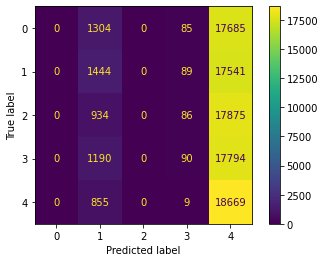

In [184]:
from sklearn.metrics import confusion_matrix, classification_report


esn = sequential_search.best_estimator_

y_pred_train = esn.predict_proba(X=dataset)
cm = confusion_matrix(np.argmax(np.concatenate(labels_hot_repeat), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(np.argmax(np.concatenate(labels_hot_repeat), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1), digits=10)))

# y_pred_test = esn.predict(X=X_test)
# cm = confusion_matrix(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1))
# cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()
# print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1), digits=10)))


In [158]:
# model from door example



initially_fixed_params = {'hidden_layer_size': 100,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_km_esn = ESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in.T),
                                    **initially_fixed_params)

try:
    sequential_search = load("RICSyN2015/sequential_search_RICSyN2015_km_large_1.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_km_esn, searches=searches).fit(dataset, labels_repeat)
    dump(sequential_search, "RICSyN2015/sequential_search_RICSyN2015_km_large_1.joblib")

NameError: name 'w_in' is not defined

In [95]:
base_esn.fit(dataset, labels_repeat)

ESNClassifier(input_to_node=InputToNode(bias_scaling=0.0,
                                        input_activation='identity', k_in=10,
                                        sparsity=0.0390625),
              node_to_node=NodeToNode(k_rec=10, sparsity=0.02),
              regressor=IncrementalRegression(), requires_sequence=True)

In [96]:
predictions = base_esn.predict(dataset)

In [97]:
correct = []
for i, prediction in enumerate(predictions):  
    
    correct.append((prediction == labels[i]).mean())

correct = np.array(correct)

In [98]:
correct.mean()

0.295484848134971

In [99]:
correct

array([0.59776536, 0.41899441, 0.23463687, 0.31843575, 0.16201117,
       0.16201117, 0.29050279, 0.22346369, 0.07821229, 0.22905028,
       0.42458101, 0.35195531, 0.34636872, 0.11731844, 0.16421442,
       0.27374302, 0.15642458, 0.39664804, 0.27374302, 0.12849162,
       0.22905028, 0.29050279, 0.29608939, 0.27932961, 0.23463687,
       0.17877095, 0.18435754, 0.57541899, 0.24022346, 0.20670391,
       0.25698324, 0.25698324, 0.22905028, 0.32960894, 0.55865922,
       0.13407821, 0.24581006, 0.4301676 , 0.38547486, 0.12849162,
       0.54189944, 0.2122905 , 0.24581006, 0.18994413, 0.26815642,
       0.585878  , 0.09497207, 0.16759777, 0.33519553, 0.36312849,
       0.22346369, 0.45251397, 0.44134078, 0.25698324, 0.56424581,
       0.40782123, 0.42458101, 0.27932961, 0.27932961, 0.24022346,
       0.32960894, 0.20670391, 0.09497207, 0.2122905 , 0.51396648,
       0.17318436, 0.2849162 , 0.51955307, 0.12295749, 0.22346369,
       0.56990679, 0.25744917, 0.22346369, 0.50837989, 0.12849